In [6]:
import os
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load yolo model from checkpoint
stigmas_model_checkpoint = "/home/etaylor/code_projects/thesis/checkpoints/stigmas_segmentation/yolo/fine_tuned/yolov8m-seg_fine_tuned.pt"

model = YOLO(stigmas_model_checkpoint)

In [7]:
import ultralytics
print(ultralytics.__version__)


8.3.56


In [19]:
image_path = "/sise/shanigu-group/etaylor/assessing_cannabis_exp/experiment_2/images/day_8_2025_01_09/greenhouse/110/IMG_3066.JPG"

image_numer = os.path.basename(image_path).split(".")[0].split("/")[-1]

print(f"Inference for image {image_numer}")

# Load the image
image = cv2.imread(image_path)

# Assuming 'model' is already loaded and 'image' is defined
# Perform inference
results = model.predict(image)

# Extract the first result
result = results[0]

# Convert the image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Inference for image IMG_3066



0: 480x640 3 stigmas, 30.9ms
Speed: 3.9ms preprocess, 30.9ms inference, 11.8ms postprocess per image at shape (1, 3, 480, 640)


In [9]:
def extract_segmented_objects(image_rgb, result, save_dir=None):
    masks = result.masks.data.cpu().numpy()  # Extract masks
    boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes for cropping

    if len(masks) == 0:
        print("No objects detected.")
        return []

    extracted_segments = []

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    for i, mask in enumerate(masks):
        # 🛠️ Ensure the mask is the same size as the image and of type uint8
        resized_mask = cv2.resize(mask, (image_rgb.shape[1], image_rgb.shape[0]))
        binary_mask = (resized_mask > 0.5).astype(np.uint8)  # Convert to binary mask

        # Apply the mask to the image
        segmented_object = cv2.bitwise_and(image_rgb, image_rgb, mask=binary_mask)

        # Crop using bounding box for precise object extraction
        x_min, y_min, x_max, y_max = map(int, boxes[i])
        cropped_object = segmented_object[y_min:y_max, x_min:x_max]
        extracted_segments.append(cropped_object)

        # Save the segmented object if save_dir is provided
        if save_dir:
            save_path = os.path.join(save_dir, f'segment_{i + 1}.png')
            cv2.imwrite(save_path, cv2.cvtColor(cropped_object, cv2.COLOR_RGB2BGR))
            print(f"Saved segmented object: {save_path}")

    return extracted_segments

# Visualize extracted segmented objects
def visualize_segmented_objects(segmented_objects):
    if not segmented_objects:
        print("No segmented objects to display.")
        return

    fig, axes = plt.subplots(1, len(segmented_objects), figsize=(16, 8))
    for idx, obj in enumerate(segmented_objects):
        if len(segmented_objects) > 1:
            axes[idx].imshow(obj)
            axes[idx].set_title(f'Segment {idx + 1}')
            axes[idx].axis('off')
        else:
            axes.imshow(obj)
            axes.set_title(f'Segment {idx + 1}')
            axes.axis('off')

    plt.tight_layout()
    plt.show()


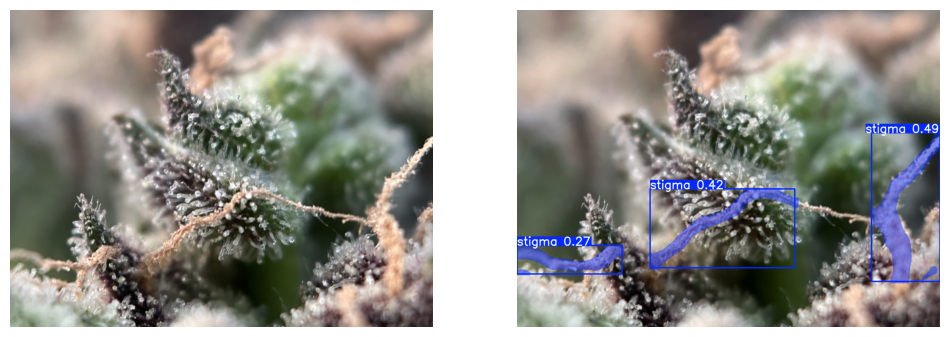

In [20]:
# Plot the results
annotated_image = results[0].plot()

# convet the image to RGB
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axes[0].imshow(image_rgb)
axes[0].axis('off')

# Plot the annotated image
axes[1].imshow(annotated_image)
axes[1].axis('off')

plt.show()

Saved segmented object: /home/etaylor/code_projects/thesis/src/stigmas_detection/segmentation/yolo/extracted_stigmas/IMG_3066/segment_1.png
Saved segmented object: /home/etaylor/code_projects/thesis/src/stigmas_detection/segmentation/yolo/extracted_stigmas/IMG_3066/segment_2.png
Saved segmented object: /home/etaylor/code_projects/thesis/src/stigmas_detection/segmentation/yolo/extracted_stigmas/IMG_3066/segment_3.png


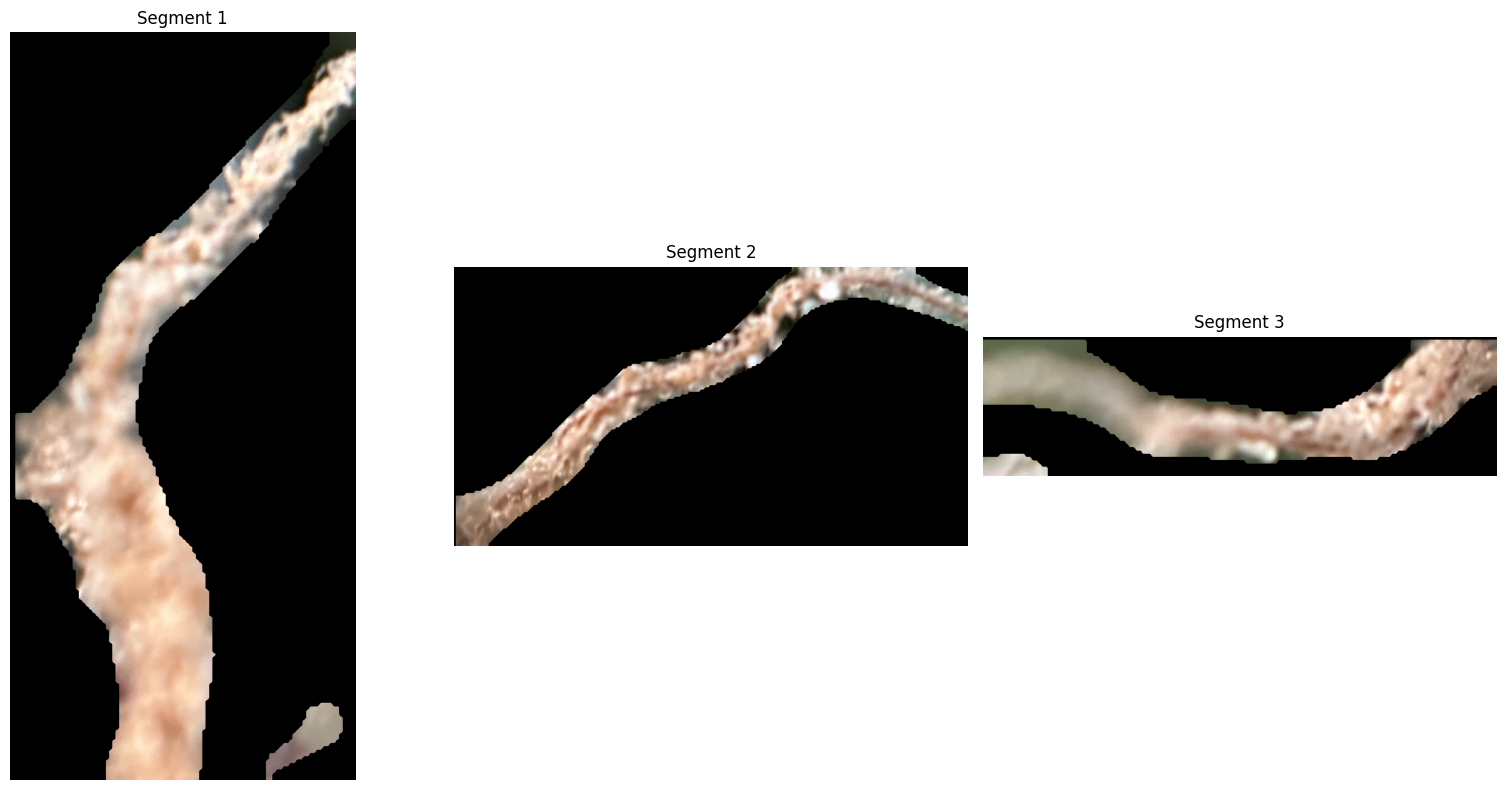

In [21]:
# Extract and visualize segmented objects
extarcted_stigmas_dir = "/home/etaylor/code_projects/thesis/src/stigmas_detection/segmentation/yolo/extracted_stigmas"
image_extracted_stigmas_dir = os.path.join(extarcted_stigmas_dir, image_numer)
segmented_objects = extract_segmented_objects(image_rgb, result, save_dir=os.path.join(extarcted_stigmas_dir, image_extracted_stigmas_dir))
visualize_segmented_objects(segmented_objects)

🔍 **Refined Stigma Extraction Strategy**
 ----------------------------------------- 

 ### **Color Filtering Within the Mask** 
   * **Problem**: Surrounding green areas blend with immature stigmas. 
   * **Solution**: Apply **color filtering** only within segmented regions to remove non-stigma green areas. 




In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def classify_stigma_colors(segmented_object):
    # Convert to HSV color space for better color detection
    hsv_image = cv2.cvtColor(segmented_object, cv2.COLOR_RGB2HSV)

    # Expanded HSV ranges for better orange and white detection
    lower_green = np.array([25, 30, 30])    # Lowered hue and saturation to detect more greens
    upper_green = np.array([95, 255, 255])

    lower_white = np.array([0, 0, 200])     # Broadened the V range for brighter whites
    upper_white = np.array([180, 60, 255])  # Increased saturation to include off-whites

    lower_orange = np.array([5, 80, 80])    # Lowered saturation and value for darker oranges
    upper_orange = np.array([30, 255, 255]) # Expanded hue for redder oranges

    # Create color masks
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)
    white_mask = cv2.inRange(hsv_image, lower_white, upper_white)
    orange_mask = cv2.inRange(hsv_image, lower_orange, upper_orange)

    # Apply morphological operations to smooth the masks
    kernel = np.ones((3, 3), np.uint8)
    white_mask = cv2.morphologyEx(white_mask, cv2.MORPH_CLOSE, kernel)
    orange_mask = cv2.morphologyEx(orange_mask, cv2.MORPH_CLOSE, kernel)

    # Plot white and orange masks for debugging
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(white_mask, cmap='gray')
    axes[0].set_title('White Mask (Refined)')
    axes[0].axis('off')
    axes[1].imshow(orange_mask, cmap='gray')
    axes[1].set_title('Orange Mask (Refined)')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

    # Count pixels in each mask
    total_pixels = np.sum((green_mask > 0) | (white_mask > 0) | (orange_mask > 0))
    green_ratio = np.sum(green_mask > 0) / total_pixels if total_pixels else 0
    white_ratio = np.sum(white_mask > 0) / total_pixels if total_pixels else 0
    orange_ratio = np.sum(orange_mask > 0) / total_pixels if total_pixels else 0

    return green_ratio, white_ratio, orange_ratio


def classify_stigma_kmeans(segmented_object, n_clusters=3):
    # Reshape the image to a 2D array of pixels
    img_data = segmented_object.reshape((-1, 3))

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(img_data)

    # Replace pixels with their cluster centers
    clustered_img = kmeans.cluster_centers_[kmeans.labels_].reshape(segmented_object.shape).astype(np.uint8)

    # Plot the result
    plt.imshow(clustered_img)
    plt.title("K-Means Color Clustering")
    plt.axis('off')
    plt.show()

    # Count the number of pixels in each cluster
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    ratios = counts / counts.sum()

    return ratios


# Helper function to display images side by side
def show_images(images, titles, figsize=(20, 10)):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Apply color filtering to extract stigma and remove green background
def apply_color_filter(segmented_object):
    hsv_image = cv2.cvtColor(segmented_object, cv2.COLOR_RGB2HSV)

    # Define HSV ranges for green, white, and orange
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])

    # Create color masks
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

    # Remove green background
    stigma_mask = cv2.bitwise_not(green_mask)

    return stigma_mask

# Apply the mask to extract the stigma
def apply_mask_on_image(image, mask):
    return cv2.bitwise_and(image, image, mask=mask)

# Full pipeline to extract stigma, classify colors, and plot results
def full_pipeline(segmented_object):
    # 1. Remove green background
    stigma_mask = apply_color_filter(segmented_object)
    
    # 2. Extract stigma
    stigma_extracted = apply_mask_on_image(segmented_object, stigma_mask)
    
    # 3. Classify stigma colors
    green_ratio, white_ratio, orange_ratio = classify_stigma_colors(stigma_extracted)
    
    # 4. Display results
    color_distribution = (
        f"Green Ratio: {green_ratio * 100:.2f}%\n"
        f"White Ratio: {white_ratio * 100:.2f}%\n"
        f"Orange Ratio: {orange_ratio * 100:.2f}%"
    )

    show_images(
        [segmented_object, stigma_extracted],
        ['Original Segmented Object', f'Stigma without Green Background\n{color_distribution}'],
        figsize=(12, 6)
    )

    return green_ratio, white_ratio, orange_ratio


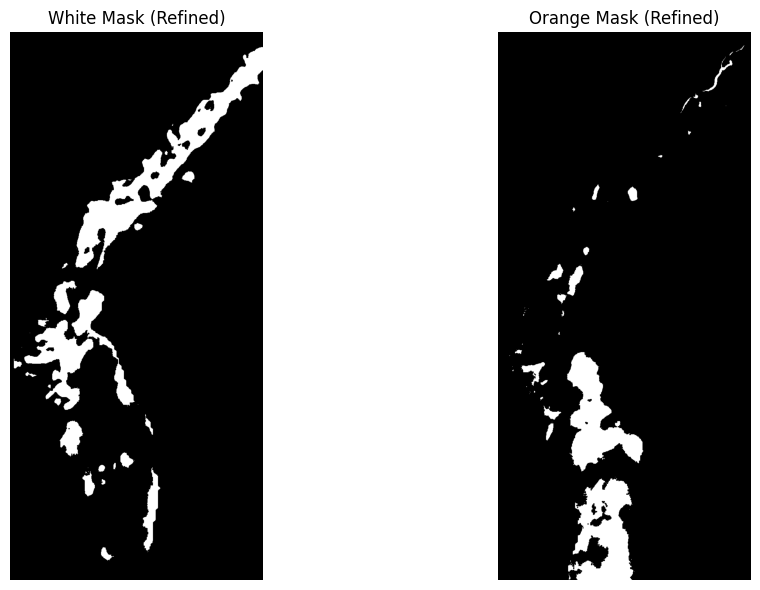

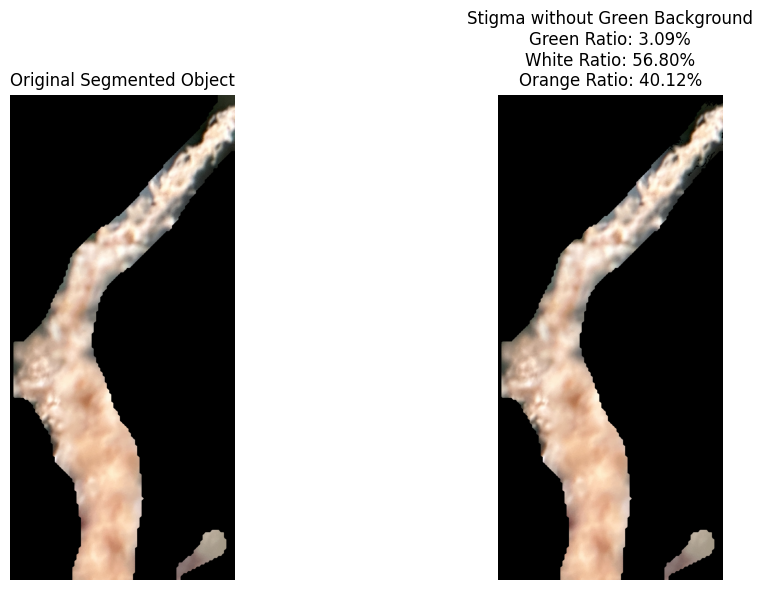

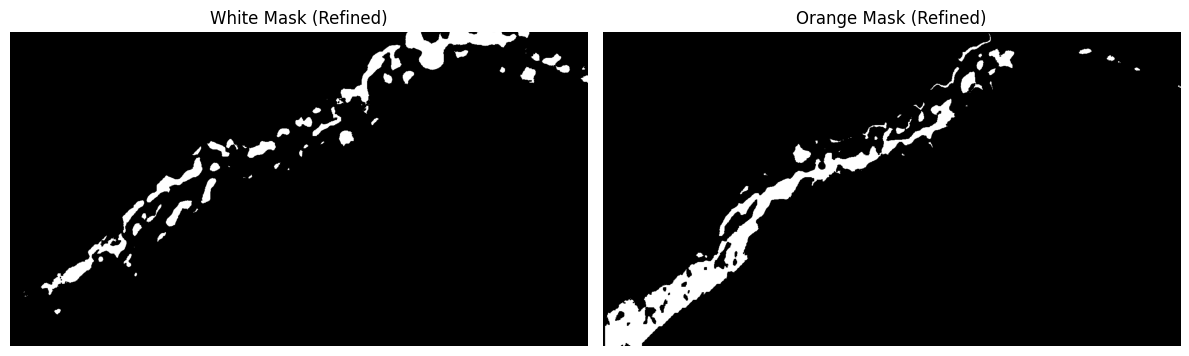

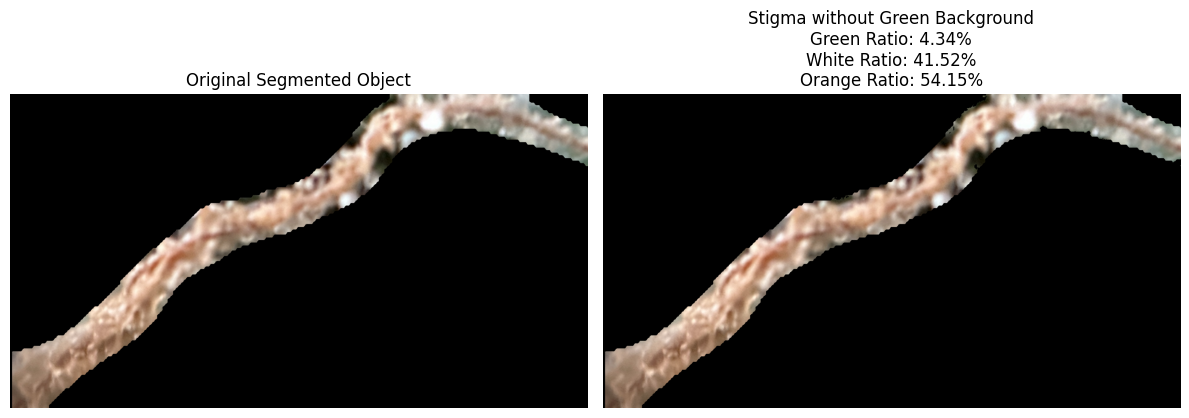

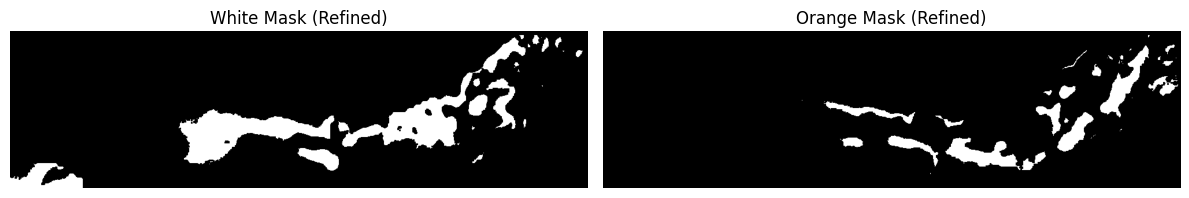

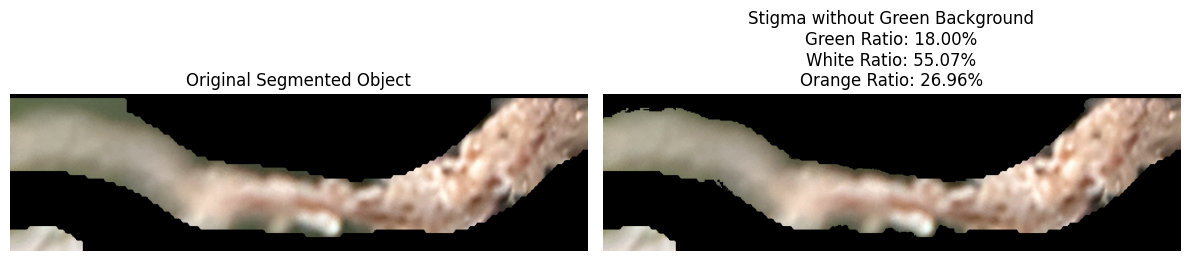

In [48]:
# Function to process all images in a folder
def process_folder_images(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)
            if image is not None:
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                full_pipeline(image_rgb)


# Process and plot all images in the folder
process_folder_images(image_extracted_stigmas_dir)


## 🔍 Enhanced Background Removal Strategies
1. **K-means Clustering for Color Segmentation:**
This method segments the image into clusters and isolates non-green regions.

2. **GrabCut Algorithm:**
A more advanced background subtraction method that intelligently separates the foreground (stigma) from the background.

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Helper function to display images side by side
def show_images(images, titles, figsize=(20, 10)):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Method 1: K-means Clustering for Background Removal
def kmeans_background_removal(image, k=2):
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape((image.shape))

    # Assume the background cluster is the most dominant
    mask = (labels.reshape((image.shape[:2])) == np.argmax(np.bincount(labels.flatten()))).astype(np.uint8) * 255
    mask = cv2.bitwise_not(mask)
    return cv2.bitwise_and(image, image, mask=mask)

# Method 2: GrabCut Algorithm for Background Removal
def grabcut_background_removal(image):
    mask = np.zeros(image.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (10, 10, image.shape[1]-10, image.shape[0]-10)
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    return image * mask2[:, :, np.newaxis]

# Function to process and compare both methods
def process_and_compare_methods(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)
            if image is not None:
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Apply K-means and GrabCut methods
                kmeans_result = kmeans_background_removal(image_rgb)
                grabcut_result = grabcut_background_removal(image_rgb)

                # Plot original, K-means, and GrabCut results
                show_images(
                    [image_rgb, kmeans_result, grabcut_result],
                    [f'Original - {filename}', 'K-means Background Removal', 'GrabCut Background Removal'],
                    figsize=(15, 5)
                )


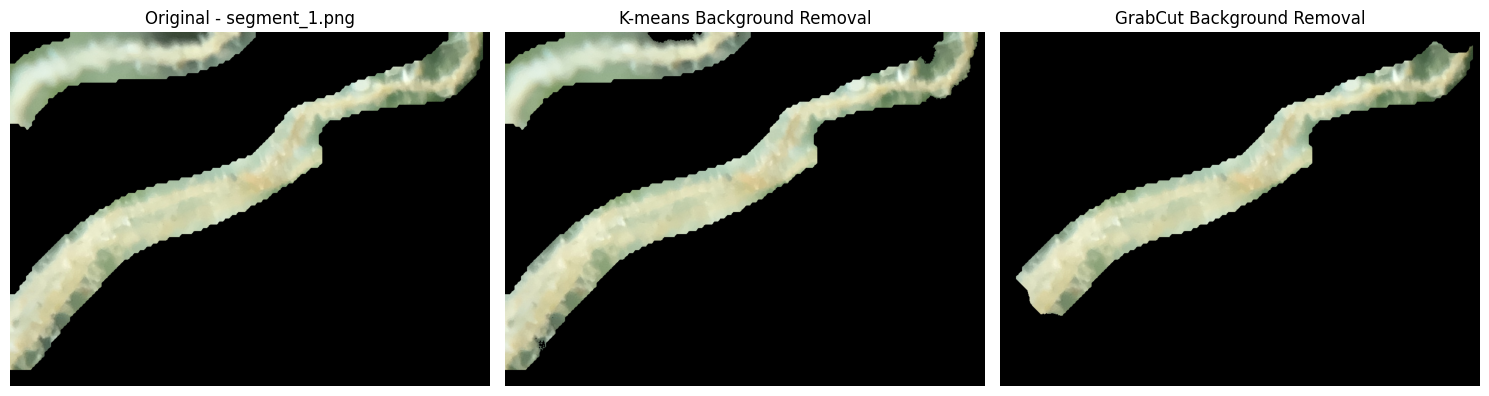

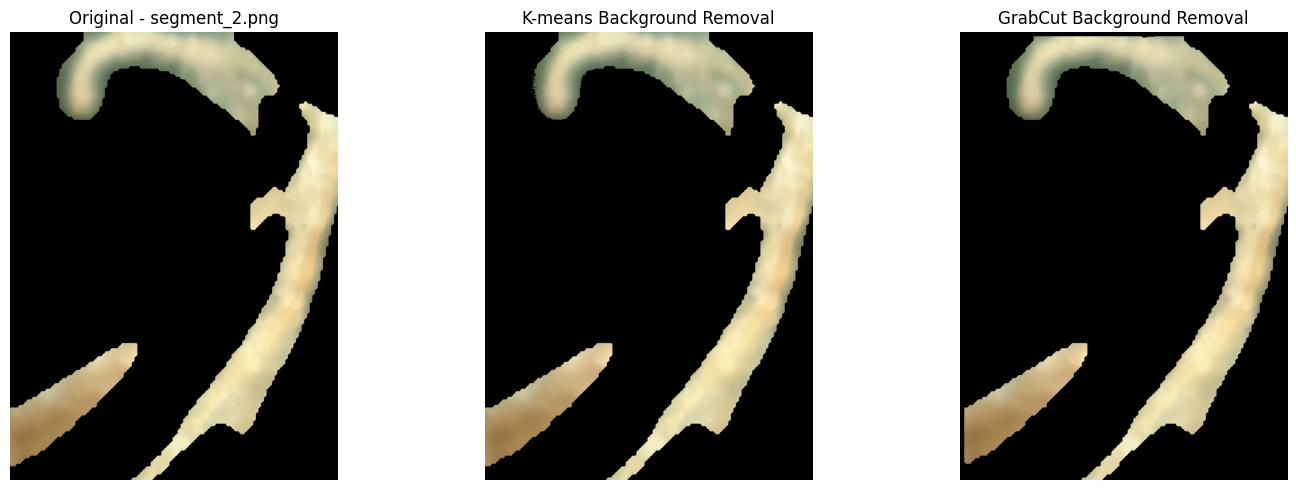

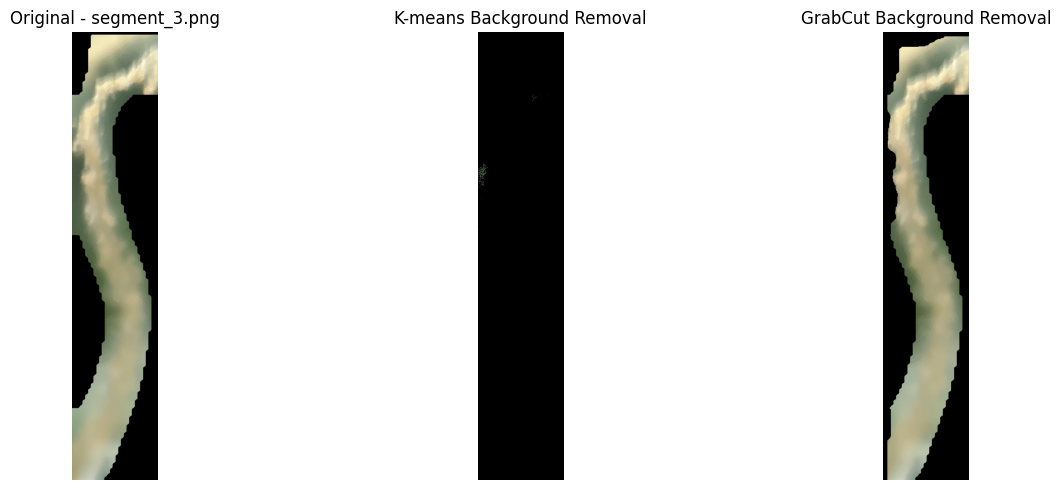

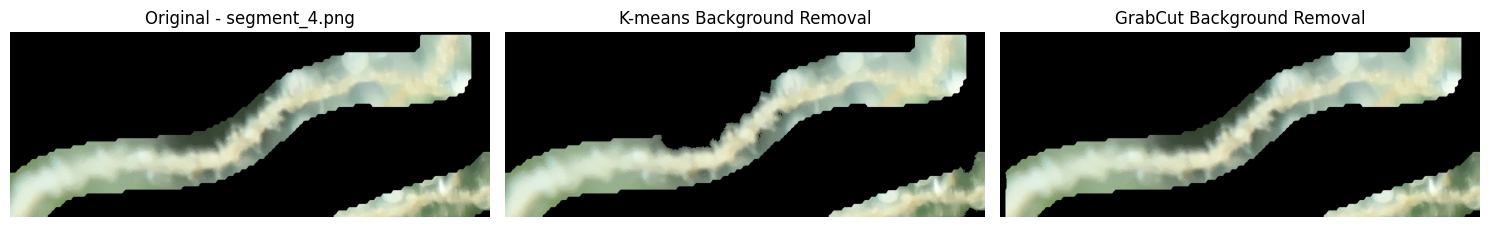

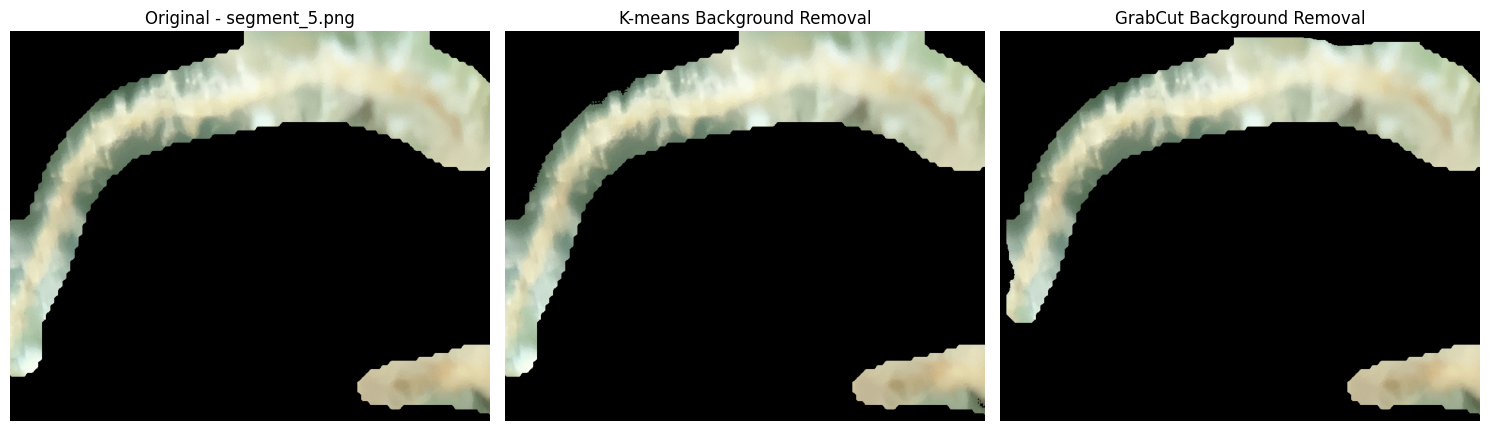

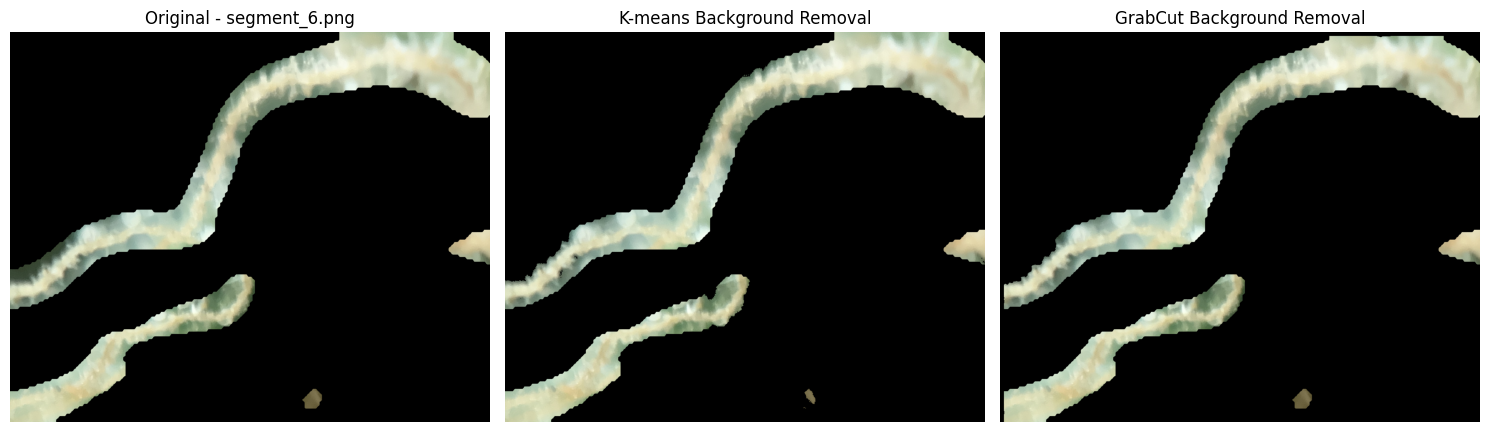

In [6]:
# Folder path containing the segmented stigma images
folder_path = "/home/etaylor/code_projects/thesis/segmented_stigmas"

# Process and compare the results of both methods
process_and_compare_methods(folder_path)